In [1]:
using Plots
using LazySets
using Random

In [2]:
function plot_points(S::Matrix{<:Real}, w::Vector{<:Integer}, Π::Vector{<:Integer}=[0])
    S = Float64.(S)
    red_points = S[w.==1, :]
    blue_points = S[w.==-1, :]

    plt = scatter(size=(500, 500), legend=:none, 
                  xlims=(minimum(S[:,1])-1, maximum(S[:,1])+1),
                  ylims=(minimum(S[:,2])-1, maximum(S[:,2])+1), 
                  axis=0, framestyle=:box,
                  grid=0, color=:white)
    
    scatter!(plt, red_points[:, 1], red_points[:, 2], color=:red)
    scatter!(plt, blue_points[:, 1], blue_points[:, 2], color=:blue)
    
    if Π != [0]
        k = maximum(Π)        
        for j = 1:k
            j_points = S[Π .== j,:]
            j_set = [j_points[i,:] for i in 1:size(j_points,1)]
            j_hull = convex_hull(j_set)
            plot!(VPolygon(j_hull), color=:gray, alpha=0.2)
        end
        SΠ_disc = [abs(sum((Π.==j) .* (w.==1)) - sum((Π.==j) .* (w.==-1))) for j=1:k]
        println("Discrepancy = ", minimum(SΠ_disc), " = min",SΠ_disc) 
    end
    
    return plt
end

plot_points (generic function with 2 methods)

In [3]:
function discrepancy(S::Matrix{<:Real},w::Vector{<:Integer},Π::Vector{<:Integer})
    k = maximum(Π)  
    SΠ_disc = [abs(sum((Π.==j) .* (w.==1)) - sum((Π.==j) .* (w.==-1))) for j=1:k]
    disc = minimum(SΠ_disc)
    return disc
end

discrepancy (generic function with 1 method)

In [5]:
function relabler(Π::Array{<:Integer}, new_names::Vector{<:Integer})
    for i = 1:length(Π)
        Π[i] = new_names[Π[i]]
    end
    return Π
end

relabler (generic function with 1 method)

In [4]:
function partitions(n::Int, k::Int)
    if k == 1
        return [1 for i in 1:n]
    elseif n == k
        return [i for i in 1:n]
    else
        ## This is essentially the recurrence of Stirling numbers of the second kind. (https://en.wikipedia.org/wiki/Stirling_numbers_of_the_second_kind)
        res = Array{Integer,2}(undef,n,0)
        for i in 1:k
            sub_par = relabler(partitions(n-1, k), circshift([j for j in 1:k],i-1))
            par = vcat(ones(Int,1,size(sub_par,2)),sub_par)
            res = hcat(res,par)
        end
        sub_par = relabler(partitions(n-1, k-1), [j for j in 2:k])
        par = vcat(ones(Int,1,size(sub_par,2)),sub_par)
        res = hcat(res,par)
        return res
    end
end

partitions (generic function with 1 method)

In [6]:
function coarseness(S::Matrix{<:Real}, w::Vector{<:Integer})
    c = 1
    Π_opt = Array{Integer,2}(undef,n,0)

    for k = 1:n
        par = partitions(n,k)

        for p = 1:size(par,2)
            Π = par[:,p]

            hulls = Array{Array{Array{Float64, 1}, 1}, 1}(undef,k)
            for j = 1:k
                j_points = S[Π .== j,:]
                j_set = [j_points[i,:] for i in 1:size(j_points,1)]
                hulls[j] = convex_hull(j_set)
            end
            flag = true
            for j = 1:k-1
                for l = j+1:k
                    flag = flag * isempty( VPolygon(hulls[j]) ∩ VPolygon(hulls[l]) )
                end
            end

            if flag 
                d = discrepancy(S,w,Π)
                if d == c
                    Π_opt = hcat(Π_opt, Π)
                elseif d > c
                    Π_opt = Π
                    c = d
                end
            end
        end
    end
    
    return c,Π_opt
end

coarseness (generic function with 1 method)

In [37]:
# OJO que esto es exponencial! con n=10 demora aprox 7min en mi compu, con 11 ya no probe...

n = 10

S = rand(n,2)
w = rand([-1,1], n)

c, Π_opt = coarseness(S,w)

println("coarseness = ", c)
Π_opt

coarseness = 2


10×28 Matrix{Integer}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  3  3  3  3  3  3     2  2  2  2  2  2  2  1  4  1  5  5
 1  1  1  1  3  2  2  3  3  3  2  2  2     2  2  2  2  2  1  3  4  3  2  4  3
 1  1  2  2  2  2  2  3  3  2  2  2  1     2  2  2  1  3  3  1  2  2  4  2  2
 1  2  3  3  1  3  3  2  2  3  2  3  2     2  3  3  3  3  1  3  3  3  5  3  3
 1  1  2  1  3  1  2  2  1  3  2  3  1  …  3  3  2  1  3  3  1  4  3  2  4  4
 1  1  1  1  1  2  2  3  3  3  3  2  3     2  2  2  2  2  2  2  1  4  3  5  5
 1  1  2  1  1  1  2  1  1  1  1  1  1     1  1  1  1  1  3  1  1  1  3  1  1
 1  1  2  2  2  2  2  2  1  2  2  2  1     2  2  2  2  2  3  1  2  2  4  2  2
 1  2  3  3  1  3  3  2  2  3  2  3  2     3  3  3  3  3  1  1  3  3  5  3  4

Discrepancy = 2 = min[2, 2, 2]


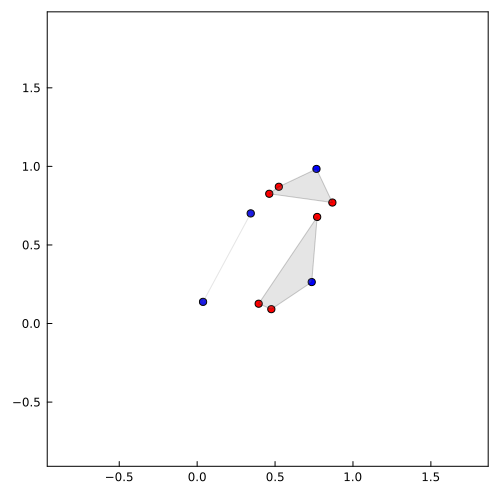

In [50]:
i = 20
plot_points(S,w,Π_opt[:,i])

In [51]:
n = 10

S = rand(n,2)
w = rand([-1,1], n)

c, Π_opt = coarseness(S,w)

println("coarseness = ", c)
Π_opt

coarseness = 2


10×20 Matrix{Integer}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  3  3  3  3  2  2  2  2  2  2  2  5  3
 1  1  1  1  1  1  1  3  3  1  1  2  2  2  2  1  1  4  3  5
 1  1  1  1  1  1  1  3  3  1  1  2  2  1  1  1  1  1  4  1
 1  1  1  1  3  2  2  1  1  1  1  1  1  2  2  1  1  1  1  2
 1  2  2  3  2  3  3  2  2  2  2  1  3  3  3  1  3  3  2  4
 1  2  1  2  3  3  2  2  3  2  3  1  1  3  2  1  1  1  4  2
 1  1  1  2  1  2  2  3  3  3  3  2  2  2  2  2  2  2  5  3
 1  2  2  3  2  3  3  2  2  2  2  3  3  3  3  3  3  3  2  4
 1  2  1  1  1  3  2  2  3  2  3  3  1  3  2  3  1  4  3  5